In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from causal_conv import CausalConv2d
from torchinfo import summary

from model_encoder import ResNet18
from torchinfo import summary

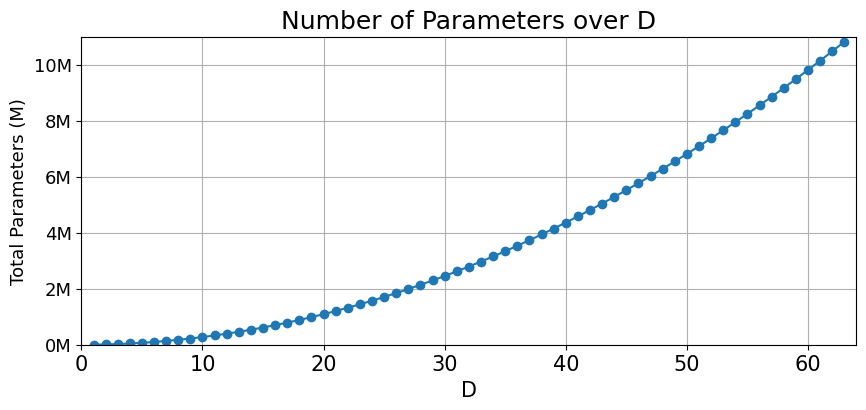

273500
1091800


In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from causal_conv import CausalConv2d
from torchinfo import summary

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, isfinal=False):
        super(BasicBlock, self).__init__()
        self.conv1 = weight_norm(CausalConv2d(in_channels, out_channels, kernel_size=3, stride=stride, bias=False))
        # self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 =  weight_norm(CausalConv2d(out_channels, out_channels, kernel_size=3, stride=1, bias=False))
        # self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.downsample = downsample  # Used for downsampling (channel modificiation)
        self.isfinal = isfinal

    def forward(self, x):
        # print("input shape", x.shape)
        identity = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        
        # Skip ReLU for Final output
        if not self.isfinal:
            out = self.relu(out)

        return out
    
##### Modified ResNet for Feature Extraction
class ResNet(nn.Module):
    def __init__(self, block, layers, in_channels=10):
        super(ResNet, self).__init__()
        self.in_channels = in_channels
        self.bottleneckdim = in_channels
        self.conv1 = weight_norm(CausalConv2d(1, self.bottleneckdim, kernel_size=(7,7), stride=(2,1), bias=False))
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=(2,1), padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(block, self.bottleneckdim, layers[0])
        self.layer2 = self._make_layer(block, self.bottleneckdim*2, layers[1], stride=(2,1))
        self.layer3 = self._make_layer(block, self.bottleneckdim*4, layers[2], stride=(2,1))
        self.layer4 = self._make_layer(block, self.bottleneckdim*8, layers[3], stride=(2,1), isfinal=True)

    def _make_layer(self, block, out_channels, blocks, stride=1, isfinal=False):
        downsample = None
        if stride != 1 : # Downsampling layer needs channel modification
            downsample = CausalConv2d(self.in_channels, out_channels,
                             kernel_size=1, stride=stride, bias=False)
                        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, isfinal=isfinal))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x
    
def ResNet18(in_channels=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], in_channels)

def count_model_parameters(in_channels):
    model = ResNet18(in_channels=in_channels)  # in_channels 변경
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

from matplotlib import pyplot as plt

# Example usage
if __name__ == "__main__":
    model = ResNet18(in_channels=4)  
    # input_tensor = torch.randn(8, 1, 832, 80)  
    # print(summary(model, input_data=input_tensor))
    # print(model)

    ######## count parameters for D
    in_channels_list = range(1, 64) 
    params_list = [count_model_parameters(in_channels) for in_channels in in_channels_list]

    plt.figure(figsize=(10,4))
    plt.plot(in_channels_list, params_list, marker='o')
    plt.xlabel('D', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=13)
    plt.ylabel('Total Parameters (M)', fontsize=13) 

    # y축 값을 K 단위로 변환 (1,000,000 단위)
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}M".format(int(x/1000_000))))
    plt.xlim(0, 64)
    plt.ylim(-5, 11000000)
    plt.title('Number of Parameters over D', fontsize=18)
    plt.grid(True)
    plt.show()

    print(count_model_parameters(10))
    print(count_model_parameters(20))


In [7]:
num_subbands = 26
data = torch.rand(8,1,32*num_subbands,80) # BxCxFxT
encoder = ResNet18()
out = encoder(data)
print(out.shape)
print(summary(encoder, input_data=torch.rand(8,1,32*num_subbands,80)))

torch.Size([8, 512, 26, 80])
Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [8, 512, 26, 80]          --
├─CausalConv2d: 1-1                      [8, 64, 416, 80]          3,200
├─ReLU: 1-2                              [8, 64, 416, 80]          --
├─MaxPool2d: 1-3                         [8, 64, 208, 80]          --
├─Sequential: 1-4                        [8, 64, 208, 80]          --
│    └─BasicBlock: 2-1                   [8, 64, 208, 80]          --
│    │    └─CausalConv2d: 3-1            [8, 64, 208, 80]          36,928
│    │    └─ReLU: 3-2                    [8, 64, 208, 80]          --
│    │    └─CausalConv2d: 3-3            [8, 64, 208, 80]          36,928
│    │    └─ReLU: 3-4                    [8, 64, 208, 80]          --
│    └─BasicBlock: 2-2                   [8, 64, 208, 80]          --
│    │    └─CausalConv2d: 3-5            [8, 64, 208, 80]          36,928
│    │    └─ReLU: 3-6                    

In [5]:
import torch
import torch.nn as nn

class m1(nn.Module):
    def __init__(self):
        super(m1, self).__init__()
        self.bottleneck_shape = 64

        # Reducing the padding and dilation to control the output size
        self.c1 = nn.ConvTranspose2d(self.bottleneck_shape, self.bottleneck_shape//2, kernel_size=(4,3), stride=(2,1), padding=(1,1), )
        self.c2 = nn.ConvTranspose2d(self.bottleneck_shape//2, self.bottleneck_shape//4, kernel_size=(4,3), stride=(2,1), padding=(1,1), )
        self.c3 = nn.ConvTranspose2d(self.bottleneck_shape//4, self.bottleneck_shape//8, kernel_size=(4,3), stride=(2,1), padding=(1,1), )
        self.c4 = nn.ConvTranspose2d(self.bottleneck_shape//8, self.bottleneck_shape//16, kernel_size=(4,3), stride=(2,1), padding=(1,1), )
        self.c5 = nn.ConvTranspose2d(self.bottleneck_shape//16, 1, kernel_size=(4,3), stride=(2,1), padding=(1,1), )

    def forward(self, x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.c3(x)
        x = self.c4(x)
        x = self.c5(x)
        return x

# Example input tensor with shape B x 512 x NumSubband x 80
input_tensor = torch.randn(out.shape)
print(input_tensor.shape)
model = m1()
output = model(input_tensor)

print("Output shape:", output.shape)  # Should be B x 1 x 320 x 80
print(summary(model, input_data=input_tensor))


torch.Size([8, 64, 64, 80])
Output shape: torch.Size([8, 1, 2048, 80])
Layer (type:depth-idx)                   Output Shape              Param #
m1                                       [8, 1, 2048, 80]          --
├─ConvTranspose2d: 1-1                   [8, 32, 128, 80]          24,608
├─ConvTranspose2d: 1-2                   [8, 16, 256, 80]          6,160
├─ConvTranspose2d: 1-3                   [8, 8, 512, 80]           1,544
├─ConvTranspose2d: 1-4                   [8, 4, 1024, 80]          388
├─ConvTranspose2d: 1-5                   [8, 1, 2048, 80]          49
Total params: 32,749
Trainable params: 32,749
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 3.85
Input size (MB): 10.49
Forward/backward pass size (MB): 94.37
Params size (MB): 0.13
Estimated Total Size (MB): 104.99


In [173]:
import torch
import torch.nn as nn
import torch.nn.utils.weight_norm as weight_norm

## Conv-ReLU-Conv with Residual Connection
class ResBlock(nn.Module):
    def __init__(self, n_ch):
        super(ResBlock, self).__init__()

        self.conv1 = weight_norm(nn.Conv2d(n_ch, n_ch, kernel_size=3, stride=1, padding=1))
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = weight_norm(nn.Conv2d(n_ch, n_ch, kernel_size=3, stride=1, padding=1))

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)

        x += identity
        out = self.relu(x)
        return out

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()


        self.c1 = weight_norm(nn.ConvTranspose2d(512, 256, kernel_size=(4,3), stride=(2,1), padding=(1,1)))
        self.conv1 = ResBlock(256)

        self.c2 = weight_norm(nn.ConvTranspose2d(256, 128, kernel_size=(4,3), stride=(2,1), padding=(1,1)))
        self.conv2 = ResBlock(128)
        
        self.c3 = weight_norm(nn.ConvTranspose2d(128, 64, kernel_size=(4,3), stride=(2,1), padding=(1,1)))
        self.conv3 = ResBlock(64)
        
        self.c4 = weight_norm(nn.ConvTranspose2d(64, 32, kernel_size=(4,3), stride=(2,1), padding=(1,1)))
        self.conv4 = ResBlock(32)
        
        self.c5 = weight_norm(nn.ConvTranspose2d(32, 1, kernel_size=(4,3), stride=(2,1), padding=(1,1)))
        self.conv5 = ResBlock(1)

    def forward(self, x):
        x = self.c1(x)
        x = self.conv1(x)
        
        x = self.c2(x)
        x = self.conv2(x)
        
        x = self.c3(x)
        x = self.conv3(x)
        
        x = self.c4(x)
        x = self.conv4(x)
        
        x = self.c5(x)
        x = self.conv5(x)
        
        return x

# Example input tensor with shape B x 512 x 10 x 80
input = torch.rand(8,1,32*10, 40)
out = encoder(input)

model = Decoder()
print(summary(model, input_data=out))


Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [8, 1, 320, 40]           --
├─ConvTranspose2d: 1-1                   [8, 256, 20, 40]          1,573,632
├─ResBlock: 1-2                          [8, 256, 20, 40]          --
│    └─Conv2d: 2-1                       [8, 256, 20, 40]          590,336
│    └─ReLU: 2-2                         [8, 256, 20, 40]          --
│    └─Conv2d: 2-3                       [8, 256, 20, 40]          590,336
│    └─ReLU: 2-4                         [8, 256, 20, 40]          --
├─ConvTranspose2d: 1-3                   [8, 128, 40, 40]          393,600
├─ResBlock: 1-4                          [8, 128, 40, 40]          --
│    └─Conv2d: 2-5                       [8, 128, 40, 40]          147,712
│    └─ReLU: 2-6                         [8, 128, 40, 40]          --
│    └─Conv2d: 2-7                       [8, 128, 40, 40]          147,712
│    └─ReLU: 2-8                         [8, 128, 40,

/home/woongjib/anaconda3/envs/env3/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
